In [1]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone
import sympy as sym
from scipy import linalg

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [2]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

In [4]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

In [23]:

def linearize_system(f, g, Qc, Rc, Qo, Ro):
    m = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
    n = [tau_x, tau_y, tau_z, f_z]
    symbols = m + n

    f_num = sym.lambdify(symbols, f)
    g_num = sym.lambdify(symbols, g)

    A_num = sym.lambdify(symbols, f.jacobian(m))
    B_num = sym.lambdify(symbols, f.jacobian(n))
    C_num = sym.lambdify(symbols, g.jacobian(m))
    D_num = sym.lambdify(symbols, g.jacobian(n))

    m_equil = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    n_equil = [0, 0, 0, 9.81 / 2]
    equil = m_equil + n_equil

    A = A_num(*equil)
    B = B_num(*equil)
    C = C_num(*equil)
    D = D_num(*equil)
    marker_equil = g_num(*equil)

    def lqr(A, B, Q, R):
        P = linalg.solve_continuous_are(A, B, Q, R)
        K = linalg.inv(R) @ B.T @ P
        return K


    K = lqr(A, B, Qc, Rc)
    L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T
    
    return A, B, C, K, L, m_equil, n_equil, marker_equil.flatten()

Qc = np.diag([1, 1, 1, 10, 10, 10, .1, .1, .1, 1, 1, 1])
Rc = np.diag([100, 100, 100, 5])

Qo = np.diag([1, 1, 1, 1, 1, 1])
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

A, B, C, K, L, m_equil, n_equil, marker_equil = linearize_system(f, g, Qc, Rc, Qo, Ro)

In [34]:
print("self.A = np.array(",A.tolist(),")")
print("self.B = np.array(",B.tolist(),")")
print("self.C = np.array(",C.tolist(),")")
print("self.K = np.array(",K.tolist(),")")
print("self.L = np.array(",L.tolist(),")")

self.A = np.array( [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] )
self.B = np.array( [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826

In [ ]:
import numpy as np

class Controller:
    def __init__(self):

        # System matrices and LQR/Observer gains
        self.A = np.array([[  0,   0,   0,   0,   0,   0,   1,   0,   0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0  ],
            [ 0,    0,    0,    0,    9.81,  0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,   -9.81,  0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ]])
        self.B = np.array([[  0,          0,          0,          0      ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          2       ],
            [434.7826087,   0,          0,          0       ],
            [  0,        434.7826087,   0,          0       ],
            [  0,          0,        250,          0      ]])
        self.C = np.array([[ 1,     0,     0,    -0.175,  0,     0,     0,     0,     0,     0,
            0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0   ],
            [ 0,     0,     1,     0,     0,     0.175,  0,     0,     0,     0,
            0,     0   ],
            [ 1,     0,     0,     0.175,  0,     0,     0,     0,     0,     0,
             0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0   ],
            [ 0,     0,     1,     0,     0,    -0.175,  0,     0,     0,     0,
              0,     0   ]])
        self.K = np.array([[-0.        , -0.1       ,  0.        ,  0.        , -0.        ,
          0.58989632, -0.        , -0.11413338,  0.        ,  0.11275426,
         -0.        ,  0.        ],
        [ 0.1       ,  0.        , -0.        , -0.        ,  0.58989632,
          0.        ,  0.11413338,  0.        ,  0.        , -0.        ,
          0.11275426, -0.        ],
        [-0.        , -0.        , -0.        ,  0.31622777, -0.        ,
          0.        , -0.        , -0.        , -0.        ,  0.        ,
         -0.        ,  0.11193669],
        [ 0.        , -0.        ,  0.4472136 ,  0.        ,  0.        ,
          0.        ,  0.        , -0.        ,  0.68353024,  0.        ,
          0.        , -0.        ]])
        self.L = np.array([[ 2.97537602, 0,          0,          2.97537602, 0,         0        ],
            [0.,          2.92711379, -0.21976816, 0,          2.92711379,  0.21976816],
            [ 0,          0,          1.09868411, 0,          0,          1.09868411],
            [-2.13087076,  0,         0,          2.13087076,  0,          0        ],
            [ 1.30543174, 0,          0,          1.30543174, 0,         0       ],
            [ 0,         -1.25581808,  0.30429738,  0,         -1.25581808, -0.30429738],
            [ 8.35286245, 0,          0,          8.35286245, 0,         0        ],
            [0,          8.1162932,  -1.19153357, 0,          8.1162932,   1.19153357],
            [0,          0.,          0.70710678,  0,          0,          0.70710678],
            [ 0,         -0.67683134,  0.20469329,  0,         -0.67683134, -0.20469329],
            [ 0.70710678, 0,          0,          0.70710678, 0,         0        ],
            [-0.70710678,  0,         0,          0.70710678,  0,          0       ]])

        # Equilibrium states and inputs
        self.me = np.zeros(12)                      
        self.ne = np.array([0., 0., 0., 4.905])  # Corrected equilibrium thrust (m*g = 0.5*9.81)
        self.markere = np.array([0., 0.175, 0., 0., -0.175, 0.])

        #Extras
        self.xhat = np.array([0.,0.,0.7,0.,0.,0.,0.,0.,0.,0.,0.,0.])
        self.emax = 2
        self.dt = 0.4
        self.t = 0

        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [3., 1., 2.]  # Pink drone color

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x,p_y,p_z,
                              yaw,0,0,
                              0,0,0,
                              0,0,0])
        self.t = 0

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        q = self.xhat[0:3]  # Current drone position
        q_goal = pos_ring + dir_ring if np.linalg.norm(pos_ring - q) < 1.25 else pos_ring - dir_ring

        if q[2] < 1 and not is_last_ring:
            q_goal += np.array([0, 0, 2])

        # Potential field parameters
        K_att = 1.0
        K_rep = 1.5
        H = 1.5  # Safety threshold distance

        # Attractive gradient
        F_att = K_att * (q_goal - q)

        # Repulsive gradient (sum from each obstacle)
        F_rep = np.zeros(3)
        for obs in pos_others:
            d = np.linalg.norm(q - obs)
            if d < H and d > 1e-6:
                rep_dir = (q - obs) / d
                F_rep += K_rep * ((1/d - 1/H) / (d**2)) * rep_dir

        # Total direction vector
        F_total = F_att + F_rep

        if np.linalg.norm(F_total) < 1e-3:
            F_total = np.array([1e-3, 0, 0])  # Avoid divide-by-zero

        # Normalize and apply speed cap
        x_des = q + self.emax * F_total / np.linalg.norm(F_total)

        return np.concatenate([x_des, np.zeros(9)])


    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)

        u = -self.K @ (self.xhat - xdes)
        y = pos_markers - self.markere

        self.xhat += ((self.A @ self.xhat) + (self.B @ u) - self.L@(self.C @ self.xhat - y))*0.04

        tau = u + self.ne
        self.t += self.dt

        tau_x = tau[0]
        tau_y = tau[1]
        tau_z = tau[2]
        f_z = tau[3]

        return tau_x, tau_y, tau_z, f_z


In [32]:
class Controller:
    def __init__(self):
        self.xhat = np.array([0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        self.dt = 0.04
        self.t = 0
        self.err_max = 2
        self.variables_to_log = ['xhat']

        self.m_equil = np.zeros(12)
        self.n_equil = np.array([0, 0, 0, 4.905])
        self.marker_equil = np.array([0., 0.175, 0., 0., -0.175, 0.])

        self.A = np.array( [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] )
        self.B = np.array( [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0, 0.0], [0.0, 434.7826086956522, 0.0, 0.0], [0.0, 0.0, 250.0, 0.0]] )
        self.C = np.array( [[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] )
        self.K = np.array( [[-7.02802926835434e-16, -0.0999999999999986, 1.5738245820107906e-16, 3.377139752552337e-16, -1.2745076632913702e-15, 0.589896318525713, -4.59133330256669e-16, -0.11413338035932656, 4.941908456705207e-16, 0.11275425963225626, -2.0034341126199624e-17, 2.259207446955832e-18], [0.10000000000000071, 8.481378451686288e-17, -1.1440271099310285e-18, -4.431195641660263e-16, 0.5898963185257191, 4.222785469833079e-16, 0.11413338035932913, 1.395257169882935e-16, 3.97896358381044e-17, -2.0034341126199624e-17, 0.11275425963225652, -3.0914273334139895e-17], [-5.552068567799909e-16, -5.008864014583137e-16, -5.392549293440564e-17, 0.31622776601683833, -9.929971271120109e-16, 6.30990870136894e-16, -3.43239004776239e-16, -2.997584390045636e-16, -1.0785339282875967e-16, 1.2990442819996031e-18, -1.7775707167130436e-17, 0.11193668803450775], [5.887708024402959e-17, -4.548729226431958e-16, 0.44721359549995826, 8.587747161417051e-17, 1.3257663458363277e-16, 1.8267224539701624e-15, 3.75523909945025e-17, -4.804387375663843e-16, 0.6835302447587515, 4.5465557801687904e-17, 3.660646497105604e-18, -1.725654285260155e-17]] )
        self.L = np.array( [[2.9753760189621783, -1.8975685621027878e-16, 7.065543595072774e-17, 2.9753760189621783, -1.8975685621027878e-16, -7.065543596323005e-17], [-2.4445935260141034e-16, 2.927113791802405, -0.21976816368497643, -1.3505435981914725e-16, 2.927113791802405, 0.21976816368497704], [2.3735205285053938e-18, 2.948675547239638e-16, 1.0986841134678103, -2.3735205410077055e-18, 2.948675547239638e-16, 1.0986841134678103], [-2.130870755866925, 3.125856936636088e-16, -2.2544107465200883e-16, 2.1308707558669235, 3.125856936636088e-16, 1.9831512568336254e-16], [1.3054317390112546, -5.449128300687553e-16, 1.177100124293737e-16, 1.3054317390112542, -5.449128300687553e-16, -1.1771001243838216e-16], [6.156234484932794e-16, -1.2558180781998671, 0.3042973803557065, 1.9186724815790805e-16, -1.2558180781998671, -0.304297380355707], [8.352862454215195, -1.5419937891928144e-15, 3.9668704755833585e-16, 8.352862454215195, -1.5419937891928144e-15, -3.9668704759951424e-16], [-2.6366083451737513e-15, 8.116293195929295, -1.1915335688477362, -1.3908675129202336e-15, 8.116293195929295, 1.1915335688477386], [-1.1388317862218315e-18, 3.990010373561443e-17, 0.7071067811865483, 1.1388317547913859e-18, 3.990010373561443e-17, 0.7071067811865483], [7.251519118558259e-16, -0.6768313358185464, 0.20469328971436315, 4.74701351321185e-16, -0.6768313358185464, -0.20469328971436349], [0.7071067811865464, -1.0479317965380113e-15, 1.62464741933e-16, 0.7071067811865459, -1.0479317965380113e-15, -1.6246474194343604e-16], [-0.7071067811865509, 3.980435726022546e-17, -3.965504790837089e-17, 0.7071067811865495, 3.980435726022546e-17, 1.0325293302925366e-16]] )

    def get_color(self):
        return [148, 0, 211]

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x, p_y, p_z, 0., 0., yaw, 0., 0., 0., 0., 0., 0.])
        self.t = 0

    def get_des(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        pos_hat = xhat[0:3]
        x_des = pos_ring - dir_ring
        if np.linalg.norm(pos_ring - pos_hat) < 1.25:
            x_des = pos_ring + dir_ring
        else:
            x_des = pos_ring - dir_ring
        if pos_hat[2] < 1 and not is_last_ring:
            x_des += np.array([0, 0, 2])
        direction = x_des - pos_hat
        x_des = pos_hat + (self.err_max * direction / np.linalg.norm(direction))
        return np.concatenate([x_des, np.zeros(9)])

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        xdes = self.get_des(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
        u = -self.K @ (self.xhat - xdes)
        y = pos_markers - self.marker_equil
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        tau = u + self.n_equil
        self.t += self.dt
        return tau[0], tau[1], tau[2], tau[3]

trial: 1 seed: 2619991090
trial: 2 seed: 4021475001
trial: 3 seed: 3839088737
trial: 4 seed: 2486331897
trial: 5 seed: 2012355494
trial: 6 seed: 3028235164
trial: 7 seed: 1637590261
trial: 8 seed: 3698485137
trial: 9 seed: 2952245883
trial: 10 seed: 1277722865
trial: 11 seed: 274754740
trial: 12 seed: 4289127185
trial: 13 seed: 562712330
trial: 14 seed: 957896492
trial: 15 seed: 3837851089
trial: 16 seed: 3194216843
trial: 17 seed: 3206550352
trial: 18 seed: 785344437
trial: 19 seed: 3655294170
trial: 20 seed: 1334924095
trial: 21 seed: 3432084682
trial: 22 seed: 3964891623
trial: 23 seed: 3655582710
trial: 24 seed: 267601690
trial: 25 seed: 4204620724
trial: 26 seed: 3232739401
trial: 27 seed: 3214012008
trial: 28 seed: 1720946513
trial: 29 seed: 4107530225
trial: 30 seed: 2118394951
trial: 31 seed: 1057587274
trial: 32 seed: 2120143580
trial: 33 seed: 334797563
trial: 34 seed: 326653806
trial: 35 seed: 3483600079
trial: 36 seed: 3506440047
trial: 37 seed: 87106031
trial: 38 seed: 394

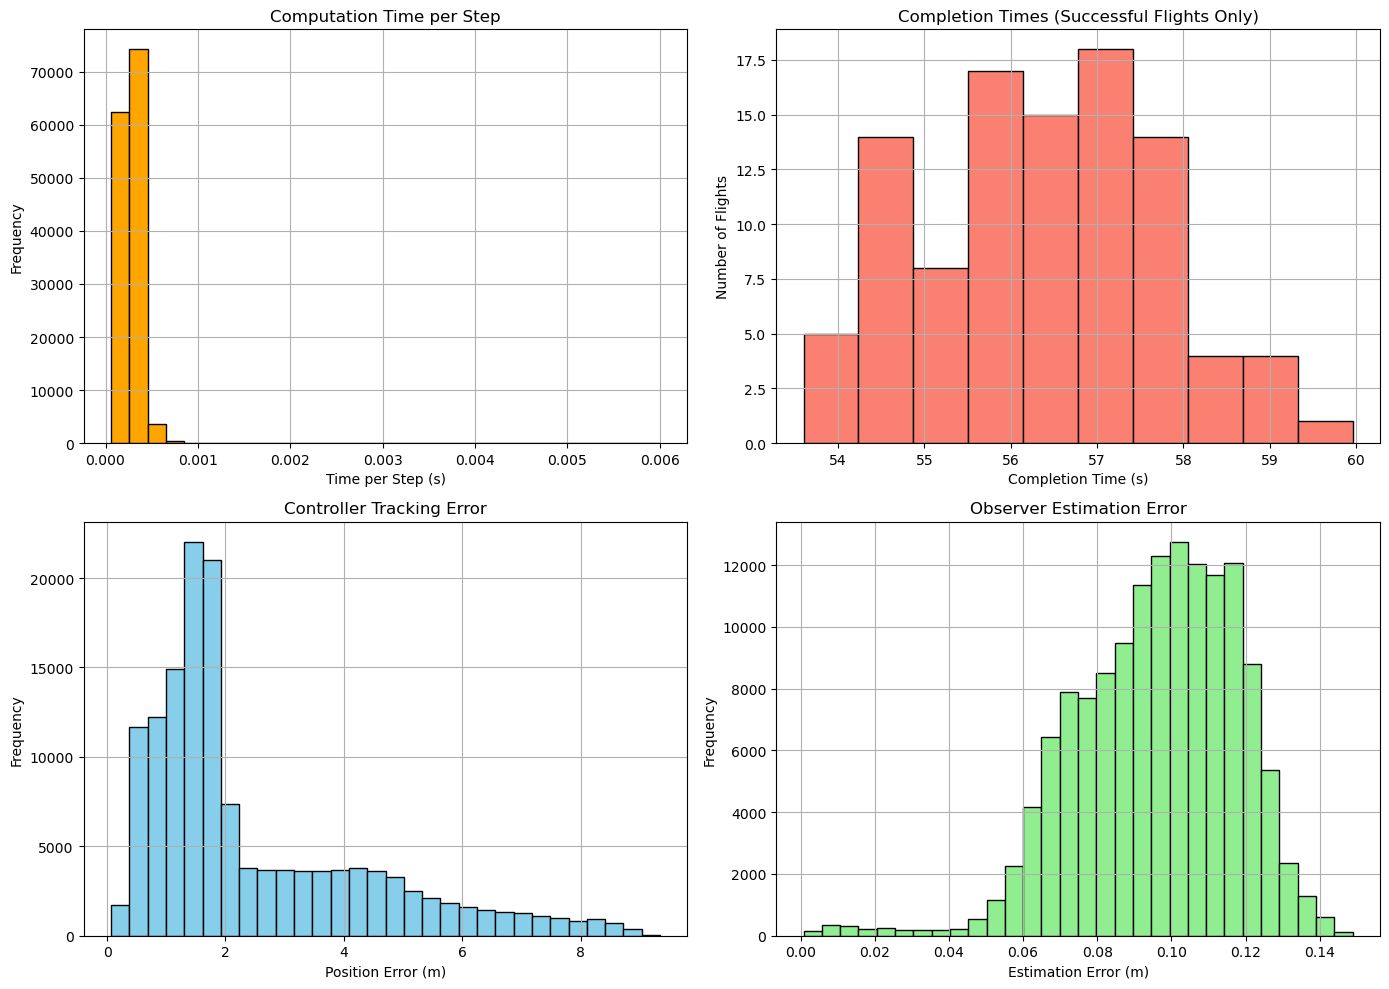


Summary for 100 trials:
Success Rate: 100.0%
Average Completion Time: 56.35 s
Fastest: 53.60 s | Slowest: 59.96 s


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Logging containers
compute_times = []
finish_times = []
success_flags = []
controller_errors = []
observer_errors = []

num_trials = 100  
i=1
for _ in range(num_trials):
    seed = secrets.randbits(32)
    print("trial:", i, "seed:", seed)
    i += 1
    simulator = ae353_drone.Simulator(seed=seed, display_pybullet=False)
    simulator.add_drone(Controller, 'wark', 'AE353FINALPROJ.png')
    simulator.reset()
    simulator.run(max_time=70., print_debug=False)

    did_fail, did_finish, t_finish = simulator.get_result('wark')
    data = simulator.get_data('wark')

    # Compute time
    compute_times.extend(data['run_time'])

    # Completion
    success_flags.append(int(did_finish and not did_fail))
    finish_times.append(t_finish if did_finish else np.nan)

    # Position logs
    actual_pos = np.stack([data['p_x'], data['p_y'], data['p_z']], axis=1)
    est_pos = np.array(data['xhat'])[:, :3]

    # Handle desired pos
    if isinstance(data['pos_ring'], list) or np.ndim(data['pos_ring']) == 2:
        desired_array = np.array(data['pos_ring'])  # already a trajectory
    else:
        desired_array = np.tile(data['pos_ring'], (len(actual_pos), 1))  # constant

    # Align lengths
    N = min(len(actual_pos), len(est_pos), len(desired_array))
    actual_pos = actual_pos[:N]
    est_pos = est_pos[:N]
    desired_array = desired_array[:N]

    # Errors
    controller_err = np.linalg.norm(desired_array - actual_pos, axis=1)
    observer_err = np.linalg.norm(est_pos - actual_pos, axis=1)
    controller_errors.extend(controller_err)
    observer_errors.extend(observer_err)

# --- Plot 4 Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. Computation Time per Step
axes[0].hist(compute_times, bins=30, color='orange', edgecolor='black')
axes[0].set_title("Computation Time per Step")
axes[0].set_xlabel("Time per Step (s)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# 2. Completion Times
valid_times = [t for t in finish_times if not np.isnan(t)]
axes[1].hist(valid_times, bins=10, color='salmon', edgecolor='black')
axes[1].set_title("Completion Times (Successful Flights Only)")
axes[1].set_xlabel("Completion Time (s)")
axes[1].set_ylabel("Number of Flights")
axes[1].grid(True)

# 3. Controller Tracking Error
axes[2].hist(controller_errors, bins=30, color='skyblue', edgecolor='black')
axes[2].set_title("Controller Tracking Error")
axes[2].set_xlabel("Position Error (m)")
axes[2].set_ylabel("Frequency")
axes[2].grid(True)

# 4. Observer Estimation Error
axes[3].hist(observer_errors, bins=30, color='lightgreen', edgecolor='black')
axes[3].set_title("Observer Estimation Error")
axes[3].set_xlabel("Estimation Error (m)")
axes[3].set_ylabel("Frequency")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# --- Summary Stats ---
print(f"\nSummary for {num_trials} trials:")
print(f"Success Rate: {np.mean(success_flags) * 100:.1f}%")
if valid_times:
    print(f"Average Completion Time: {np.mean(valid_times):.2f} s")
    print(f"Fastest: {np.min(valid_times):.2f} s | Slowest: {np.max(valid_times):.2f} s")
else:
    print("No successful flights.")



# HOPEFULLY I WAKE UP AND THIS SHIT DIDN'T BREAK

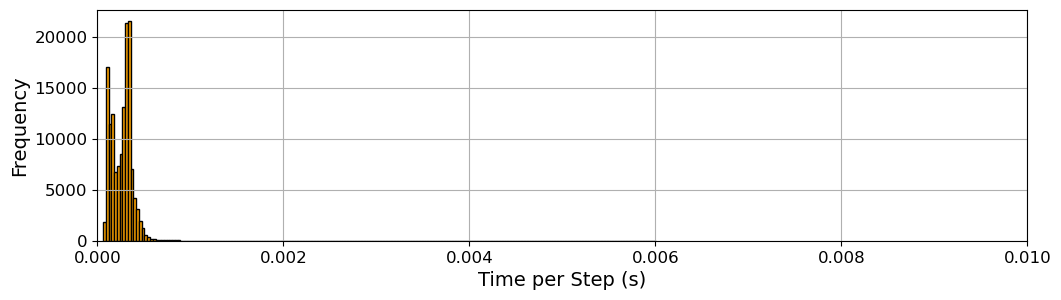

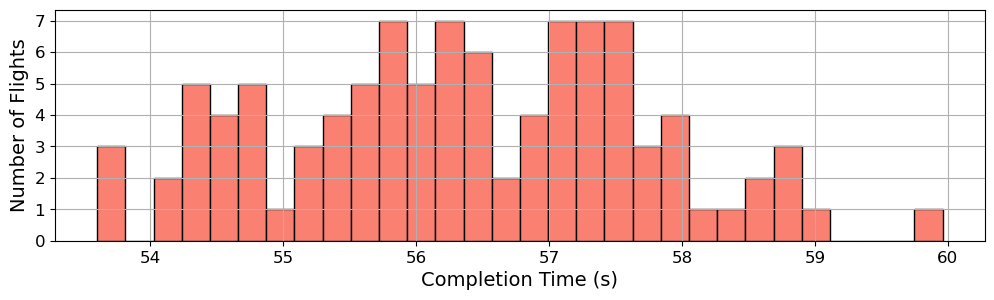

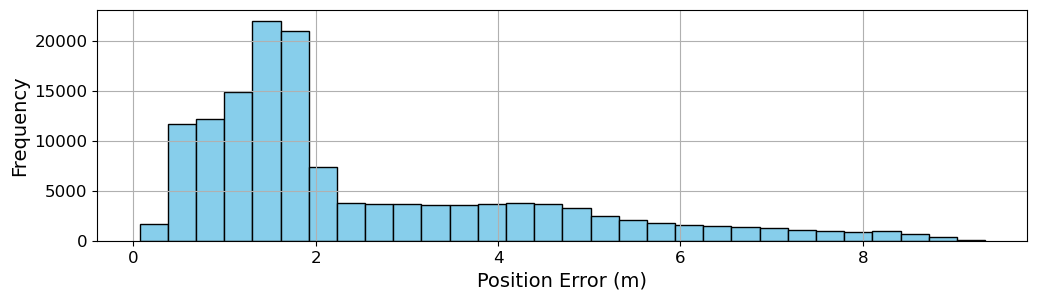

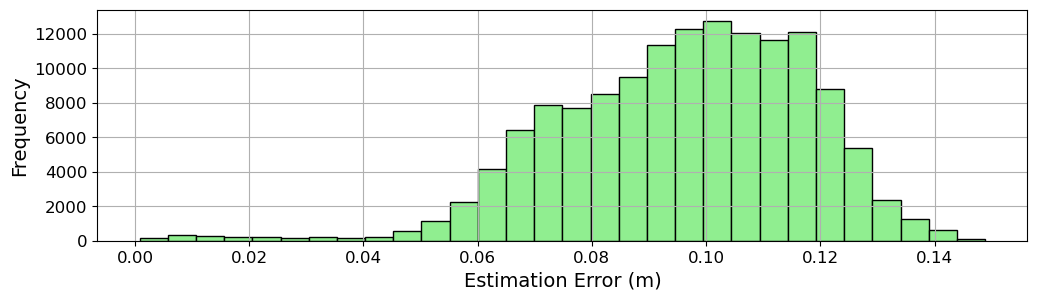

In [35]:
# 1. Computation Time per Step
plt.figure(figsize=(12, 3))
plt.hist(compute_times, bins=200, color='orange', edgecolor='black')
# plt.title("Computation Time per Step", fontsize=16)
plt.xlabel("Time per Step (s)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.xlim(0,0.010)
plt.grid(True)
plt.show()

# 2. Completion Times
valid_times = [t for t in finish_times if not np.isnan(t)]
plt.figure(figsize=(12, 3))
plt.hist(valid_times, bins=30, color='salmon', edgecolor='black')
# plt.title("Completion Times (Successful Flights Only)", fontsize=16)
plt.xlabel("Completion Time (s)", fontsize=14)
plt.ylabel("Number of Flights", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# 3. Controller Tracking Error
plt.figure(figsize=(12, 3))
plt.hist(controller_errors, bins=30, color='skyblue', edgecolor='black')
# plt.title("Controller Tracking Error", fontsize=16)
plt.xlabel("Position Error (m)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.grid(True)
plt.show()

# 4. Observer Estimation Error
plt.figure(figsize=(12, 3))
plt.hist(observer_errors, bins=30, color='lightgreen', edgecolor='black')
# plt.title("Observer Estimation Error", fontsize=16)
plt.xlabel("Estimation Error (m)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.grid(True)
plt.show()


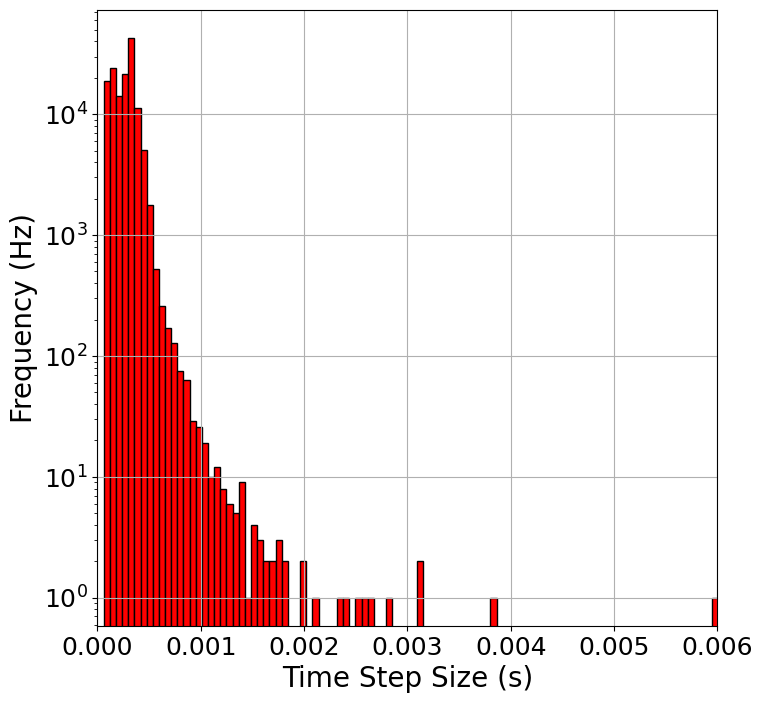

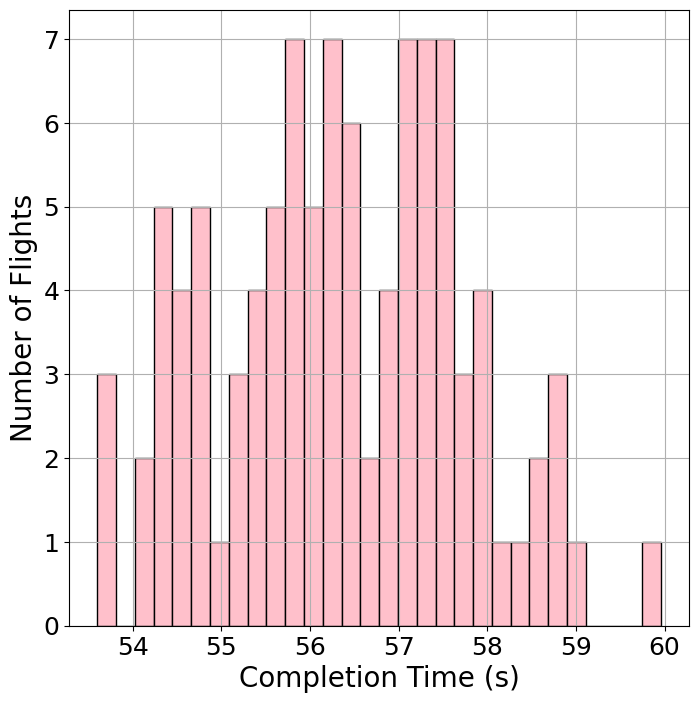

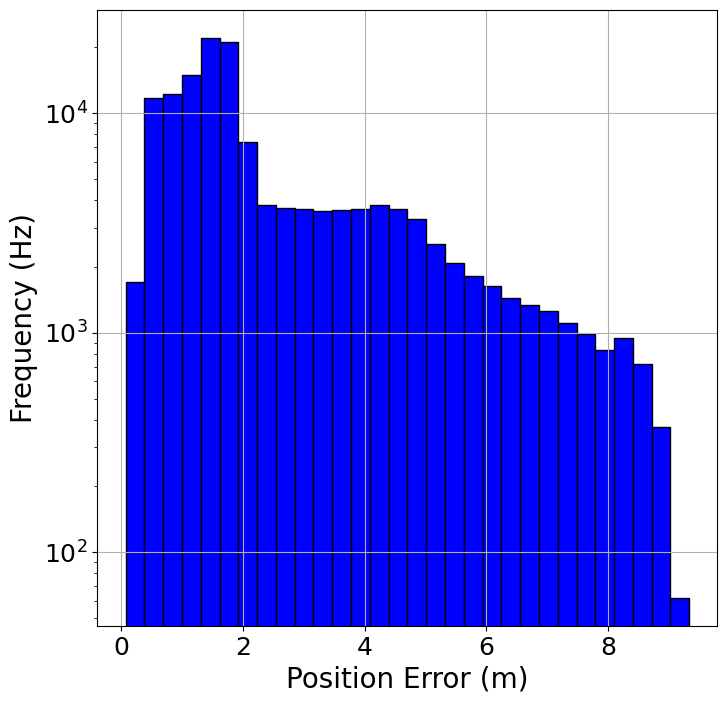

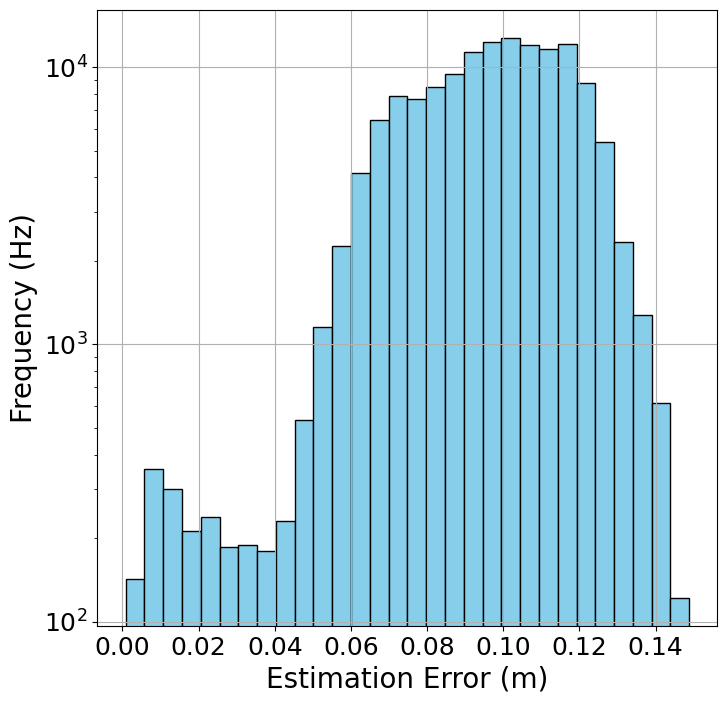

In [41]:
# 1. Computation Time per Step
plt.figure(figsize=(8, 8))
plt.hist(compute_times, bins=100, color='red', edgecolor='black')
# plt.title("Computation Time per Step", fontsize=16)
plt.xlabel("Time Step Size (s)", fontsize=20)
plt.ylabel("Frequency (Hz)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.xlim(0,0.006)
plt.grid(True)
plt.show()

# 2. Completion Times
valid_times = [t for t in finish_times if not np.isnan(t)]
plt.figure(figsize=(8, 8))
plt.hist(valid_times, bins=30, color='pink', edgecolor='black')
# plt.title("Completion Times (Successful Flights Only)", fontsize=16)
plt.xlabel("Completion Time (s)", fontsize=20)
plt.ylabel("Number of Flights", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

# 3. Controller Tracking Error
plt.figure(figsize=(8, 8))
plt.hist(controller_errors, bins=30, color='blue', edgecolor='black')
# plt.title("Controller Tracking Error", fontsize=16)
plt.xlabel("Position Error (m)", fontsize=20)
plt.ylabel("Frequency (Hz)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.grid(True)
plt.show()

# 4. Observer Estimation Error
plt.figure(figsize=(8, 8))
plt.hist(observer_errors, bins=30, color='skyblue', edgecolor='black')
# plt.title("Observer Estimation Error", fontsize=16)
plt.xlabel("Estimation Error (m)", fontsize=20)
plt.ylabel("Frequency (Hz)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.grid(True)
plt.show()

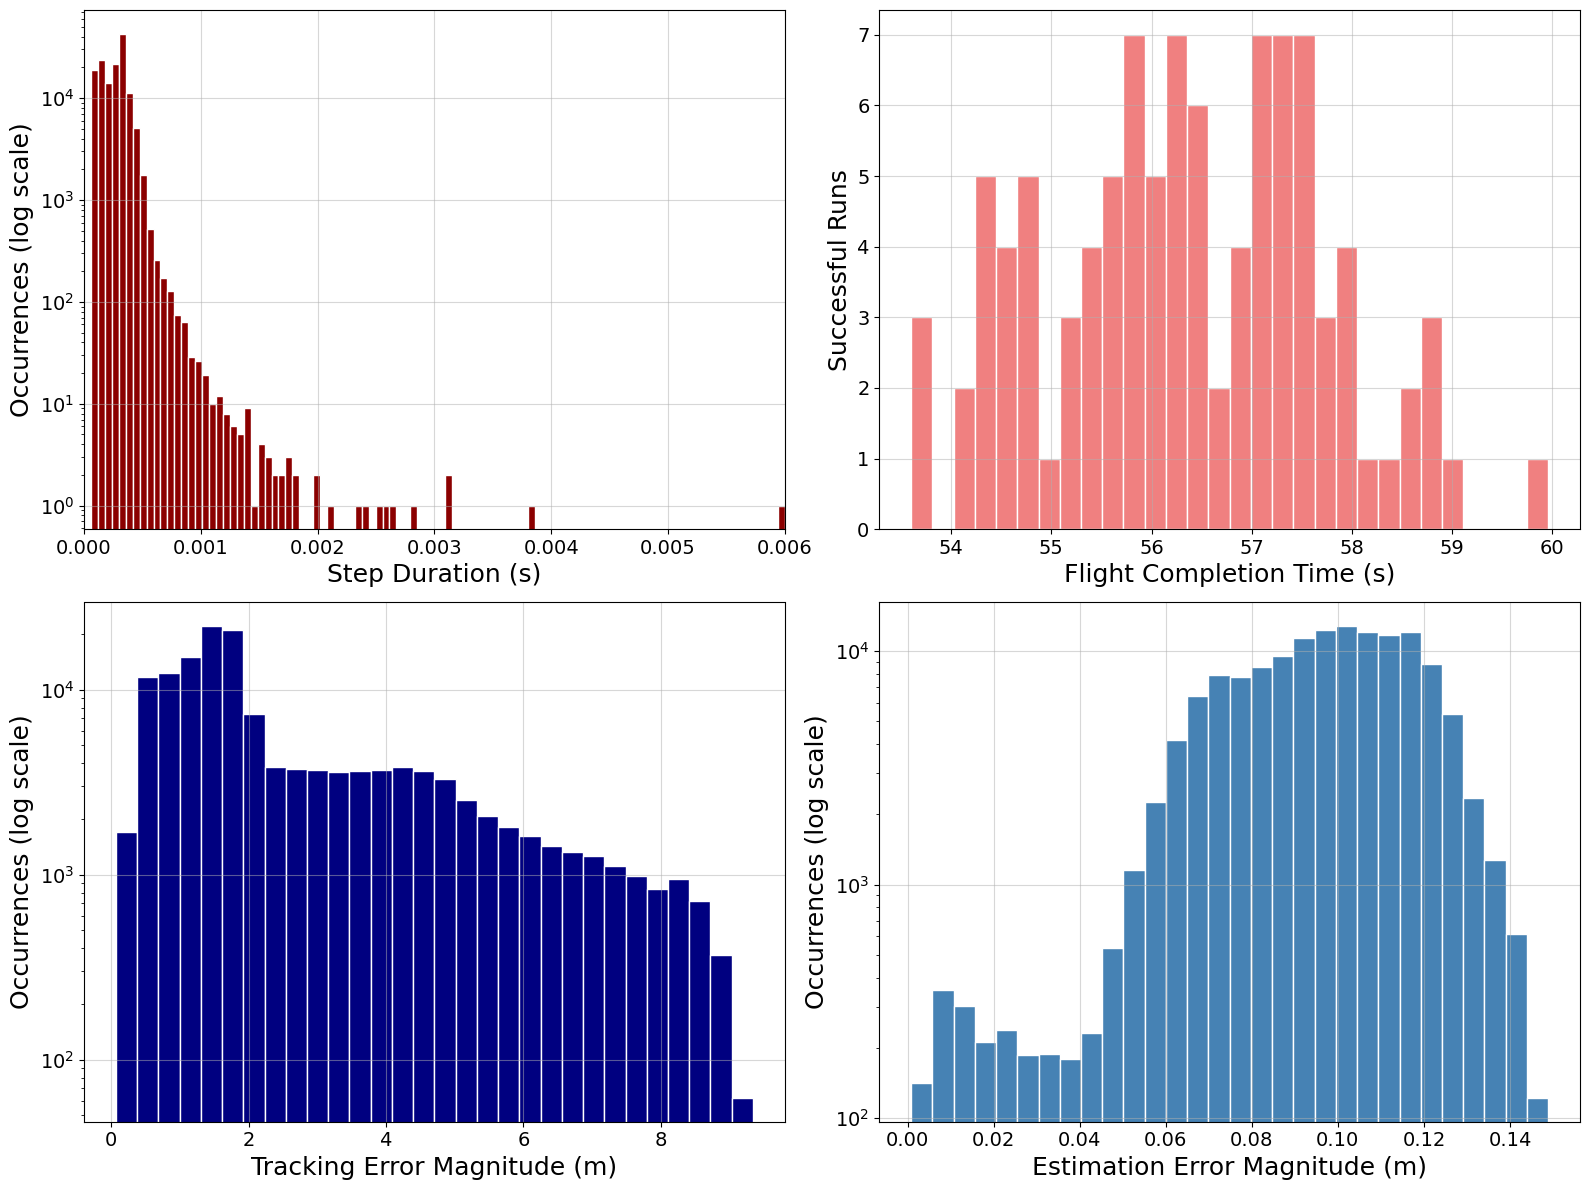

In [42]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 1. Computation Time per Step
axes[0].hist(compute_times, bins=100, color='darkred', edgecolor='white')
axes[0].set_xlabel("Step Duration (s)", fontsize=18)
axes[0].set_ylabel("Occurrences (log scale)", fontsize=18)
axes[0].set_yscale('log')
axes[0].set_xlim(0, 0.006)
axes[0].grid(alpha=0.5)
axes[0].tick_params(axis='both', labelsize=14)

# 2. Completion Times
valid_times = [t for t in finish_times if not np.isnan(t)]
axes[1].hist(valid_times, bins=30, color='lightcoral', edgecolor='white')
axes[1].set_xlabel("Flight Completion Time (s)", fontsize=18)
axes[1].set_ylabel("Successful Runs", fontsize=18)
axes[1].grid(alpha=0.5)
axes[1].tick_params(axis='both', labelsize=14)

# 3. Controller Tracking Error
axes[2].hist(controller_errors, bins=30, color='navy', edgecolor='white')
axes[2].set_xlabel("Tracking Error Magnitude (m)", fontsize=18)
axes[2].set_ylabel("Occurrences (log scale)", fontsize=18)
axes[2].set_yscale('log')
axes[2].grid(alpha=0.5)
axes[2].tick_params(axis='both', labelsize=14)

# 4. Observer Estimation Error
axes[3].hist(observer_errors, bins=30, color='steelblue', edgecolor='white')
axes[3].set_xlabel("Estimation Error Magnitude (m)", fontsize=18)
axes[3].set_ylabel("Occurrences (log scale)", fontsize=18)
axes[3].set_yscale('log')
axes[3].grid(alpha=0.5)
axes[3].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()
